## Zhlukovanie - Vyhodnotenie a interpretácia zhlukov - príklad 1

Nasledujúci príklad demonštruje zhlukovanie nákupných dát ako v minulotýždňovom príklade. 

Tentoraz sa zameriame na iné kritériá pre vyhodnotenie kvality a kompaktnosti zhlukov a ich interpretáciu nie pomocou vizualizácií, ale pomocou rozhodovacích stromov. 

Najprv si importujeme potrebné knižnice pre prácu s dátovými rámcami, poľami a pre vykresľovanie grafov. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Do dátového rámca načítame vstupné dáta zo súboru. Vypíšeme prvých 5 záznamov.  

In [3]:
data = pd.read_csv('../data/wholesale.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Rovnako ako v predošlom cvičení transformujeme dáta pomocou One Hot Encoderu (oba atribúty obsahujúce kategorické dáta) a 5 prvých záznamov transformovaného datasetu vypíšeme na obrazovku. 

In [4]:
data = pd.get_dummies(data, columns=['Channel', 'Region']) 
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


Keďže budeme vytvárať K-Means model, tak numerické atribúty normalizujeme použitím MinMaxScaler-u. 

In [7]:
from sklearn.preprocessing import MinMaxScaler # importujeme MinMaxScaler

scaler = MinMaxScaler() # Inicializujeme transformátor
scaler.fit(data) # aplikujeme ho na vstupné dáta

# po aplikovaní scaleru budeme mať výstup vo forme numpy poľa
# to môžeme - ale nemusíme - naspať transformovať do pandas rámca (ak chceme ešte robiť nejaké predspracovanie)
# funkcie pre trénovanie modelov potom vedia pracovať aj s pandas aj s numpy

# data_norm = scaler.transform(data)
data_norm = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

#### Kritérium Silhouette 

Okrem sumy štvorocov vzdialeností od reprezentanta zhluku môžeme použiť viacero iných metrík, ktoré definujú kvalitu jednotlivých zhlukov. Tie má zmysel použiť:
* tam, kde nepoužívame metódy, ktoré vytvárajú reprezentantov zhlukov
* vtedy, ak chceme použiť iné kritérium, ako používa samotný algorimtus 

Jedným z takýchto kritérií je index Silhouette. Ten udáva koeficient, vypočítaný pre každý príklad a spriemernený pre celú dátovú množinu. Koeficient kombinuje priemernú hodnotu metriky vnútro-zhlukovej vzdialenosti s priemernou vzdialenosťou k najbližšiemu zhluku. Koeficient nadobúda hodnoty od -1 a 1 (pre každý príklad). Hodnota blízka nule znamená, že príklad je pravdepodobne zaradený do nesprávneho zhluku a hodnoty bližšie k 1 vyjadrujú, že príklad je regulérnym prvkom predikovaného zhluku a dobre odlíšiteľný od ostatných. Koeficient Silhouette v scikit-learn potom vypočítava priemernú hodnotu pre všetky príklady. To potom umožňuje porovnať viacero zhlukovacích modelov (s rôznymi počtami zhlukov) navzájom. 

Podobne ako v prípade hľadania správnej hodnoty zhlukov pomocou sumy štvorcov vzdialeností, môžeme v cykle povytvárať viacero modelov, ktoré prostredníctvom tohoto kritéria evaluujeme.

In [8]:
from sklearn.cluster import KMeans # importujeme knižnicu pre KMeans
from sklearn.metrics import silhouette_score # importujeme funkciu pre výpočet Silhouette

# použijeme Silhouette score pre počet zhlukov
# môžeme potom porovnať ideálne počty zhlukov pre rôzne kritériá

K = range(2,10) # vygenerujeme pole parametrov (počet zhlukov)

results = [] 

# v cykle vytvoríme pre každú hodnotu parametra zhlukovací model, počet zhlukov zodpovedá hodnote iterátora

for k in K:
    model = KMeans(n_clusters = k)
    model.fit(data_norm)
    predictions = model.predict(data_norm) # pre výpočet silhouette priradíme príklady zo vstupných dát do zhlukov
    results.append(silhouette_score(data_norm, predictions)) # vypočítame skóre a priradíme ho do znoznamu, v ktorom budeme ukladať všetky skóre


In [9]:
# výsledky môžeme vypísať na obrazovku
# zoznam obsahuje Silhouette skóre pre parametre, v poradí, v akom boli vytvárané

print(results)

[0.5683105632788534, 0.6758522994678243, 0.7517817626189348, 0.8139267553776266, 0.8486555986404499, 0.8250031450482495, 0.669713876397921, 0.6606557084846866]


Ak chceme, skóre Silhouette vieme vizualizovať rovnakým spôsobom ako v prípade sumy štvorcov vzdialeností od centroidu. 

### Úloha 13.1:

Použite matplotlib rovnako ako v úlohách z predošlého cvičenia na vykreslenie závislosti počtu zhlukov od Silhouette skóre.

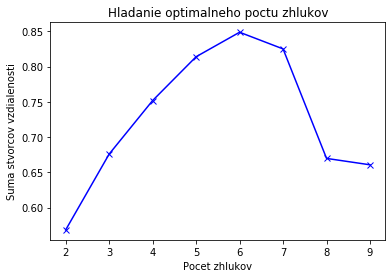

In [10]:
# YOUR CODE HERE

plt.plot(K, results, 'bx-') # 
plt.xlabel('Pocet zhlukov')
plt.ylabel('Suma stvorcov vzdialenosti')
plt.title('Hladanie optimalneho poctu zhlukov')
plt.show()

Teraz môžeme natrénovať model s najlepšim skóre. 

In [11]:
model = KMeans(n_clusters=6) # vytvoríme model pre stanovený počet zhlukov
model.fit(data_norm) # naučíme na trénovacej množine

labels = model.predict(data_norm) # vstupné dáta zatriedime do zhlukov

In [12]:
# na príslušnosť príkladov do zhlukov sa môžeme pozrieť vypísaním ich predikcií
print(labels)

[2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 1 2 1 2 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 2 1
 2 2 1 1 1 2 2 2 2 2 2 2 2 1 1 2 2 1 1 2 2 1 1 2 2 2 2 1 2 1 2 1 1 1 1 1 2
 2 1 1 2 1 1 1 2 2 1 2 2 2 1 1 1 1 1 2 1 2 1 2 1 1 1 2 2 2 1 1 1 2 2 2 2 1
 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 2 2 1 2 2 2 1 1 2 2 2 2 1 1 1 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 1 1 1 2 1 1 0 5 0 0 5 5 0 0 0 5 0 5 0 5 0 5 0 0 5 0 5 0 5 0 0 0
 0 5 0 0 5 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 5 0 0 0 0 0 0 0
 0 0 0 0 0 5 0 5 0 5 0 0 0 0 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 4 3 4
 3 4 4 3 4 4 4 4 4 4 4 3 3 4 3 3 4 3 3 4 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 4 3
 4 4 4 3 3 3 3 2 2 1 2 1 1 2 2 1 2 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1
 2 1 1 2 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 2 2 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1]


Podstatnou informáciou môže byť aj početnosť jednotlivých zhlukov v rámci vstupných dát. Tú si môžeme jednoducho spočítať z `labels` a to tak, že spočítame počty výskytov rôznych prvkov poľa výsledkov zhlukovania.

In [13]:
clusters, counts = np.unique(labels, return_counts=True) # pomocou funkcie unique identifikujeme rôzne hodnoty a vrátime aj ich počty
print(np.asarray((clusters, counts))) # aby sme "krajšie" naformátovali výstup, spojíme ich do numpy poľa

[[  0   1   2   3   4   5]
 [ 59 211 105  28  19  18]]


### Interpretácia zhlukov pomocou rozhodovacích stromov


Jednou z možností (okrem skúmania hodnôt atribútov atď.), ako interpretovať výsledné zhluky je postaviť nad danými zhlukmi klasifikačné modely, ktoré umožnia príklady patriace do daného zhluku nejakým spôsobom popísať. Ideálnym pre tento účel sú rozhodovacie stromy - pomocou nich môžeme odvodiť pravidlá, ktorými popíšeme podmienky príslušnosti príkladov k jednotlivým zhlukom. 

V takomto prípade je proces nasledovný - zhlukovaním si vlastne z pohľadu klasifikácie "vygenerujeme" cieľový atribút. Jednotlivé zhluky potom v podstate predstavujú jeho jednotlivé hodnoty - triedy. K vstupným dátam môžeme teda priradiť "cieľový atribút", ktorý ale teraz vyjadruje príslušnosť príkladu do konkrétneho zhluku. Nad takýmito dátami teda môžeme vytvoriť stromový model - ktorý je reprezentovateľný a pochopiteľný, keďže našim cieľom je vytvorené zhluky pochopiť a porozumieť im, ideálne aj popísať napr. pomocou kombinácie hodnôt atribútov.

Keď použijeme vstupné dáta (`data`) a vektor príslušnosti príkladov do zhlukov (`labels`), vytvoríme tak v podstate dvojicu matica príznakov a vektor hodnôt cieľového atribútu, ktoré používame v klasifikácii. Dáta sú potom pripravené v takej podobe, že ich môžeme použiť na trénovanie klasifikačných modelov.

In [14]:
# dátový rámec data v podstate zodpovedá matici príznakov
# stĺpec hodnôt cieľového atribútu zodpovedá vektoru hodnôt cieľového atribútu

X_train = data
y_train = labels

In [15]:
print(X_train.shape)
print(y_train.shape)

(440, 11)
(440,)


### Úloha 13.3.:

Natrénujte vhodne zvolený typ modelu na vstupných dátach. V prípade potreby ešte dodatočne predspracujte dáta. Zvoľte metódu pre nájdenie parametrov, alebo parametre modelu odhadnite.

In [16]:
# YOUR CODE HERE

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=4) # mozeme testovat vhodnost parametrov modelu
dt.fit(X_train, y_train)

y_dt = dt.predict(X_train)

{'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8], 'min_samples_split': [2, 4, 8, 10], 'min_samples_leaf': [1, 5, 10, 15], 'presort': [True, False]}
Najlepšia kombinácia parametrov je:
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'presort': True}

A hodnota presnosti modelu pri tejto kombinacii je:
1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Úloha 13.4:

Natrénujte model s vhodnými parametrami na vstupných dátach a zobrazte preň `confusion_matrix`. Porovnajte výslednú maticu s výsledkami početnosti jednotlivých zhlukov.  

In [17]:
# YOUR CODE HERE

from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier(max_depth=3)   # Napr. pouzijeme model s najvacsou hlbkou 3 - ak nam staci takyto hlboky strom   
dt.fit(X_train, y_train) # Trénovanie modelu na trénovacej množine 
y_dt = dt.predict(X_train)

# Otestovanie modelu na testovacej množine

from sklearn.metrics import accuracy_score,precision_score, recall_score # vypočítanie metrík kvality modelu

print(f"Presnosť (accuracy) modelu: {accuracy_score(y_train, y_dt)}")

cm = confusion_matrix(y_train, y_dt)  # vypísanie kontigenčnej tabuľky
print(cm)

Presnosť (accuracy) modelu: 1.0
[[ 59   0   0   0   0   0]
 [  0 211   0   0   0   0]
 [  0   0 105   0   0   0]
 [  0   0   0  28   0   0]
 [  0   0   0   0  19   0]
 [  0   0   0   0   0  18]]


### Úloha 13.4:

Použite kód z príkladov z predchádzajúcich cvičení a pokúste sa vizualizovať vytvorený model. Viete pomocou znalostí, ktoré z jeho štruktúry odvodíte popísať jednotlivé triedy, resp. zhluky?

In [18]:
# YOUR CODE HERE

from sklearn import tree
from sklearn.tree import export_graphviz

with open("decision_tree.txt", "w") as f:
    f = tree.export_graphviz(dt, feature_names=X_train.columns.values, class_names=["0","1","2","3","4","5"], out_file=f)
    
# Strom nasledne mozeme vykreslit cez www.webgraphviz.com a skusit odvodit pravidla pre popis zhlukov - pravidla mozu zhluky charakterizovat